DATA LOADING


In [ ]:
from google.colab import files
import pandas as pd
import os

# Set directory paths
DATASET_DIR = './Automated Essay Scoring'
GLOVE_DIR = './glove.6B'
SAVE_DIR = './'

In [ ]:

os.makedirs(DATASET_DIR, exist_ok=True)
os.makedirs(GLOVE_DIR, exist_ok=True)
os.makedirs(SAVE_DIR, exist_ok=True)

In [ ]:
X = pd.read_csv( '/content/drive/MyDrive/AES/training_set_rel3.tsv',  sep='\t', encoding='ISO-8859-1')

# Extract target variable
y = X['domain1_score']

# Data cleaning steps
X = X.dropna(axis=1)  # Remove columns with missing values
X = X.drop(columns=['rater1_domain1', 'rater2_domain1'])  # Drop unnecessary columns

# Preview the dataset
print(X.head())


   essay_id  essay_set                                              essay  \
0         1          1  Dear local newspaper, I think effects computer...   
1         2          1  Dear @CAPS1 @CAPS2, I believe that using compu...   
2         3          1  Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...   
3         4          1  Dear Local Newspaper, @CAPS1 I have found that...   
4         5          1  Dear @LOCATION1, I know having computers has a...   

   domain1_score  
0              8  
1              9  
2              7  
3             10  
4              8  


In [ ]:
# Display the dataset
print(X)

       essay_id  essay_set                                              essay  \
0             1          1  Dear local newspaper, I think effects computer...   
1             2          1  Dear @CAPS1 @CAPS2, I believe that using compu...   
2             3          1  Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...   
3             4          1  Dear Local Newspaper, @CAPS1 I have found that...   
4             5          1  Dear @LOCATION1, I know having computers has a...   
...         ...        ...                                                ...   
12971     21626          8   In most stories mothers and daughters are eit...   
12972     21628          8   I never understood the meaning laughter is th...   
12973     21629          8  When you laugh, is @CAPS5 out of habit, or is ...   
12974     21630          8                                 Trippin' on fen...   
12975     21633          8   Many people believe that laughter can improve...   

       domain1_score  
0   

In [ ]:
minimum_scores = [-1, 2, 1, 0, 0, 0, 0, 0, 0]
maximum_scores = [-1, 12, 6, 3, 3, 4, 4, 30, 60]

DATA PREPROCESSING


In [ ]:
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from gensim.models import Word2Vec

# Download the NLTK stopwords dataset
nltk.download('stopwords')

##TEXT PREPROSSESING

def essay_to_wordlist(essay_v, remove_stopwords):  #imput of string to be processed and remove commonly used meaningless words
    """Remove the tagged labels and word tokenize the sentence."""
    essay_v = re.sub("[^a-zA-Z]", " ", essay_v) #remove non-letters and replace wih space
    words = essay_v.lower().split() #tokenizing (text to lowercase and splits text into individual words)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops] #filtering to remove common stopwords
    return (words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def essay_to_sentences(essay_v, remove_stopwords):
    """Sentence tokenize the essay and call essay_to_wordlist() for word tokenization."""
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw_sentences = tokenizer.tokenize(essay_v.strip()) #splits essay into sentences
    sentences = []
    for raw_sentence in raw_sentences:  #list of sentences
        if len(raw_sentence) > 0:
            sentences.append(essay_to_wordlist(raw_sentence, remove_stopwords))  #sentence into words and added to sentence list
    return sentences

In [ ]:

def makeFeatureVec(words, model, num_features):
    # Initialize a feature vector with zeros
    featureVec = np.zeros((num_features,), dtype="float32")
    num_words = 0.

    # Use the updated way to access the vocabulary in Gensim 4.x
    index2word_set = set(model.wv.key_to_index)  # Corrected for Gensim 4.x

    # Iterate over each word in the list of words and add its vector to the feature vector
    for word in words:
        if word in index2word_set:
            featureVec = np.add(featureVec, model.wv[word])  # Use .wv to access the vector
            num_words += 1

    # If no words were found in the vocabulary, return the zero vector
    if num_words > 0:
        featureVec = np.divide(featureVec, num_words)

    return featureVec


In [ ]:
def getAvgFeatureVecs(essays, model, num_features):
    """
    Generate feature vectors for a list of essays.
    """
    counter = 0
    essayFeatureVecs = np.zeros((len(essays), num_features), dtype="float32")
    for essay in essays:
        essayFeatureVecs[counter] = makeFeatureVec(essay, model, num_features)
        counter += 1
    return essayFeatureVecs


In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

DEFINING  & TRAINING THE MODEL

In [ ]:
# DEFINING THE MODEL
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K
import nltk

def get_model():
    """Define the model."""
    model = Sequential()
    # First LSTM layer with dropout
    model.add(LSTM(300, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, 300], return_sequences=True))
    # Second LSTM layer with recurrent dropout
    model.add(LSTM(64, recurrent_dropout=0.4))
    # Dropout layer
    model.add(Dropout(0.5))
    # Output layer with ReLU activation
    model.add(Dense(1, activation='relu'))

    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])
    model.summary()

    return model

In [ ]:
# DEFINING THE MODEL
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K
import nltk

def get_model():
    """Define the model."""
    model = Sequential()
    # First LSTM layer with dropout
    model.add(LSTM(300, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, 300], return_sequences=True))
    # Second LSTM layer with recurrent dropout
    model.add(LSTM(64, recurrent_dropout=0.4))
    # Dropout layer
    model.add(Dropout(0.5))
    # Output layer with ReLU activation
    model.add(Dense(1, activation='relu'))

    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])
    model.summary()

    return model
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import cohen_kappa_score
from gensim.models import Word2Vec
import numpy as np

cv = KFold(n_splits=5, shuffle=True)
results = []
y_pred_list = []

count = 1
for traincv, testcv in cv.split(X):
    print("\n--------Fold {}--------\n".format(count))

    # Split into train and test sets
    X_test, X_train, y_test, y_train = X.iloc[testcv], X.iloc[traincv], y.iloc[testcv], y.iloc[traincv]

    train_essays = X_train['essay']
    test_essays = X_test['essay']

    sentences = []

    for essay in train_essays:
        # Obtaining all sentences from the training essays.
        sentences += essay_to_sentences(essay, remove_stopwords=True)

    # Initializing variables for Word2Vec model.
    num_features = 300
    min_word_count = 40
    num_workers = 4
    context = 10
    downsampling = 1e-3

    print("Training Word2Vec Model...")
    model = Word2Vec(
        sentences,
        workers=num_workers,
        vector_size=num_features,
        min_count=min_word_count,
        window=context,
        sample=downsampling
    )   # Train the Word2Vec model
    model.save("word2vec.model")

    # Generate training and testing data word vectors.
    clean_train_essays = []
    for essay_v in train_essays:
        clean_train_essays.append(essay_to_wordlist(essay_v, remove_stopwords=True))
    trainDataVecs = getAvgFeatureVecs(clean_train_essays, model, num_features)
    trainDataVecs = np.array(trainDataVecs)

    # Ensure testDataVecs is properly defined
    clean_test_essays = []
    for essay_v in test_essays:
        clean_test_essays.append(essay_to_wordlist(essay_v, remove_stopwords=True))
    testDataVecs = getAvgFeatureVecs(clean_test_essays, model, num_features)
    testDataVecs = np.array(testDataVecs)

    # Reshaping train and test vectors to 3 dimensions. (1 represents one timestep)
    trainDataVecs = np.reshape(trainDataVecs, (trainDataVecs.shape[0], 1, trainDataVecs.shape[1]))
    testDataVecs = np.reshape(testDataVecs, (testDataVecs.shape[0], 1, testDataVecs.shape[1]))

    # Train the LSTM model
    lstm_model = get_model()
    lstm_model.fit(trainDataVecs, y_train, batch_size=64, epochs=50)

    # Predict on the test data
    y_pred = lstm_model.predict(testDataVecs)

    # Save the model when count is 5
    if count == 5:
        lstm_model.save('./final_lstm.h5')

    # Round y_pred to the nearest integer
    y_pred = np.around(y_pred)

    # Evaluate the model on the evaluation metric "Quadratic mean averaged Kappa"
    result = cohen_kappa_score(y_test.values, y_pred, weights='quadratic')
    print("Kappa Score: {}".format(result))

    # Append the result to the list
    results.append(result)

    # Increment the count for the next iteration
    count += 1






--------Fold 1--------

Training Word2Vec Model...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1, 300)              │         721,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          93,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 814,705 (3.11 MB)

 Trainable params: 814,705 (3.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 75.9197 - mae: 4.6350
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 30.9249 - mae: 2.8085
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 22.7763 - mae: 2.3780
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 16.8348 - mae: 2.1149
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 12.7989 - mae: 1.9053
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 11.7464 - mae: 1.8534
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 10.9043 - mae: 1.7983
Epoch 8/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 9.5746 - mae: 1.7299
Epoch 9/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 8.6683 - mae: 1.6335
Epoch 10/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 8.1351 - mae: 1.5956
Epoch 11/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 9.2278 - mae: 1.6179
Epoch 12/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 9.0099 - mae: 1.6612
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 1, 300)              │         721,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          93,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 814,705 (3.11 MB)

 Trainable params: 814,705 (3.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 77.8415 - mae: 4.7882
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 36.3833 - mae: 2.9492
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 24.9785 - mae: 2.4397
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 18.3340 - mae: 2.1783
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 13.3909 - mae: 1.9252
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 11.1471 - mae: 1.8281
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 10.2335 - mae: 1.7649
Epoch 8/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 10.0502 - mae: 1.7115
Epoch 9/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 9.4462 - mae: 1.6847
Epoch 10/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 9.3433 - mae: 1.6283
Epoch 11/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 8.7706 - mae: 1.5972
Epoch 12/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 8.6142 - mae: 1.6177
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 1, 300)              │         721,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 64)                  │          93,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 814,705 (3.11 MB)

 Trainable params: 814,705 (3.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 77.4039 - mae: 4.7576
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 35.2502 - mae: 2.9408
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 24.1225 - mae: 2.4208
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 17.1107 - mae: 2.1073
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 13.3401 - mae: 1.9524
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 11.9717 - mae: 1.8699
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 9.9929 - mae: 1.7551
Epoch 8/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 10.2198 - mae: 1.7236
Epoch 9/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 9.6732 - mae: 1.6901
Epoch 10/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 9.0259 - mae: 1.6479
Epoch 11/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 9.6463 - mae: 1.6416
Epoch 12/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 9.6909 - mae: 1.6502
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 1, 300)              │         721,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 64)                  │          93,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 814,705 (3.11 MB)

 Trainable params: 814,705 (3.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 71.3469 - mae: 4.5965
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 35.0568 - mae: 3.0302
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 24.8661 - mae: 2.5162
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 17.5686 - mae: 2.1932
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 13.0019 - mae: 1.9576
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 11.5337 - mae: 1.8726
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 11.1213 - mae: 1.8297
Epoch 8/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 10.4037 - mae: 1.7312
Epoch 9/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 8.8170 - mae: 1.6585
Epoch 10/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 8.4569 - mae: 1.6254
Epoch 11/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 9.1477 - mae: 1.6391
Epoch 12/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 9.0238 - mae: 1.6062
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 1, 300)              │         721,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 64)                  │          93,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 814,705 (3.11 MB)

 Trainable params: 814,705 (3.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 73.0286 - mae: 4.6821
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 33.7532 - mae: 2.8675
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 22.1154 - mae: 2.3236
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 18.2551 - mae: 2.1917
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 12.7720 - mae: 1.9259
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 11.1707 - mae: 1.8270
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 10.2911 - mae: 1.7568
Epoch 8/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 9.6396 - mae: 1.6942
Epoch 9/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 9.4587 - mae: 1.7098
Epoch 10/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 8.7291 - mae: 1.6488
Epoch 11/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 9.2846 - mae: 1.6418
Epoch 12/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 8.1170 - mae: 1.5694
Epoch 

Kappa Score: 0.9688274518240388


In [ ]:
# DEFINING THE MODEL
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K
import nltk
from gensim.models import KeyedVectors

# Load the pre-trained Word2Vec model from local file
model_path = "/content/drive/MyDrive/AES/word2vec.model"  # Path to your local Word2Vec model
print("Loading pre-trained Word2Vec model from local path...")
try:
    word2vec_model = KeyedVectors.load(model_path)  # Load the model
    print("Word2Vec model loaded successfully.")
except Exception as e:
    raise Exception(f"Error loading Word2Vec model: {e}")


Loading pre-trained Word2Vec model from local path...
Word2Vec model loaded successfully.


In [ ]:
from gensim.downloader import load
from gensim.models import KeyedVectors
import numpy as np
import os

#Additional prediction testing

class Question:
    max_score = 10  # Define the maximum score for predictions

question = Question()

# Test essay content
content = "He is a very bad student."

if len(content) > 20:  # Minimum content length check
    num_features = 300  # Dimensionality of Word2Vec embeddings

    # Load the pre-trained Word2Vec model from local file
    model_path = "/content/drive/MyDrive/AES/word2vec.model"
    print("Loading pre-trained Word2Vec model from local path...")
    try:
        word2vec_model = KeyedVectors.load(model_path)
        print("Word2Vec model loaded successfully.")
    except Exception as e:
        raise Exception(f"Error loading Word2Vec model: {e}")
    # Clean and process the input essay
    print("Cleaning and processing the input essay...")
    clean_test_essays = [essay_to_wordlist(content, remove_stopwords=True)]

    # Generate feature vectors for the essay
    print("Generating feature vectors...")
    testDataVecs = getAvgFeatureVecs(clean_test_essays, word2vec_model, num_features)
    print(f"Feature vectors shape: {testDataVecs.shape}")

    testDataVecs = np.array(testDataVecs)
    testDataVecs = np.reshape(testDataVecs, (testDataVecs.shape[0], 1, testDataVecs.shape[1]))
    print(f"Reshaped feature vectors shape: {testDataVecs.shape}")

    #
    current_path = os.getcwd()

    # Load the LSTM model weights
    print("Loading LSTM model weights...")
    lstm_model = get_model()
    lstm_model.load_weights(os.path.join(current_path, "/content/drive/MyDrive/AES/final_lstm.h5"))
    print("LSTM model weights loaded successfully.")

    # Make predictions
    print("Making predictions...")
    preds = lstm_model.predict(testDataVecs)
    print(f"Prediction output: {preds}")

    # Check if preds is a scalar or an array
    if preds.ndim > 1:
        preds = preds.flatten()
    print(f"Flattened prediction shape: {preds.shape}")

    if np.isnan(preds).any():
        print("NaN detected in predictions, setting preds to 0.")
        preds = 0
    else:
        preds = np.around(preds)
        print(f"Predictions after rounding: {preds}")


    preds = max(0, min(preds, question.max_score))
    print(f"Final prediction (after range adjustment): {preds}")

else:
    preds = 0


Loading pre-trained Word2Vec model from local path...
Word2Vec model loaded successfully.
Cleaning and processing the input essay...
Generating feature vectors...
Feature vectors shape: (1, 300)
Reshaped feature vectors shape: (1, 1, 300)
Loading LSTM model weights...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 1, 300)              │         721,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          93,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 814,705 (3.11 MB)

 Trainable params: 814,705 (3.11 MB)

 Non-trainable params: 0 (0.00 B)

LSTM model weights loaded successfully.
Making predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
Prediction output: [[2.2599998]]
Flattened prediction shape: (1,)
Predictions after rounding: [2.]
Final prediction (after range adjustment): [2.]


TESTING PREDICTIONS WITH ESSAY CONENT FROM DATASET


In [ ]:
from gensim.downloader import load
from tensorflow.keras.models import load_model
import numpy as np
import os

# Sample essay content from dataset to compare predicted score with actual score
content = "Dear, In this world today we should have everyone useing computers. Computers have a positive effect on people. They teach hand-eye coordination, give people the ability to learn about faraway places and people, and even allow people to talk online with other people. Today computers are like the worlds biggest book of knowledge. everything you need to know is in a computer. You can look up faraway places, and zap theres everything you need to know write in front of you. Computers are fast and easy, everyone can use them. Today kids are so addicted to computers everyday they are on them. There are so many websites that kids and teens go on, like @CAPS1, and facebook ect. on these websites kids as young as ten years old are chatting with friends and putting up pictures. Thers is also webchat websites that allow you to use a webcame and talk to people anywhere in the world. Computers are a great way to get in touch with people. Everyone should have a computer in there home today."

if len(content) > 20:
    num_features = 300

    # Load the pre-trained Word2Vec model
    print("Loading pre-trained Word2Vec model...")
    try:
        word2vec_model = load("word2vec-google-news-300")  # Downloads and loads the Word2Vec model
        print("Word2Vec model loaded successfully.")
    except Exception as e:
        raise Exception(f"Error loading Word2Vec model: {str(e)}")

    # Preprocess the essay content
    clean_test_essays = []
    clean_test_essays.append(essay_to_wordlist(content, remove_stopwords=True))

    # Generate feature vectors for the test content
    print("Generating feature vectors...")
    testDataVecs = getAvgFeatureVecs(clean_test_essays, word2vec_model, num_features)
    testDataVecs = np.array(testDataVecs)
    testDataVecs = np.reshape(testDataVecs, (testDataVecs.shape[0], 1, testDataVecs.shape[1]))
    print(f"Reshaped feature vectors shape: {testDataVecs.shape}")

    # Load the trained LSTM model
    print("Loading trained LSTM model...")
    lstm_model_path = "/content/final_lstm.h5"
    if not os.path.exists(lstm_model_path):
        raise Exception(f"LSTM model file not found at {lstm_model_path}")
    lstm_model = load_model(lstm_model_path)
    print("LSTM model loaded successfully.")

    # Make predictions
    print("Making predictions...")
    preds = lstm_model.predict(testDataVecs)
    print(f"Raw prediction output: {preds}")

    # Process predictions
    if preds.ndim > 1:
        preds = preds.flatten()  # Flatten to a 1D array if necessary
    preds = np.around(preds)  # Round predictions to the nearest integer
    preds = max(0, min(preds[0], 10))  # Adjust predictions to the range (0-10)

    print(f"Final prediction score: {preds}")

else:
    preds = 0
    print("Content too short for prediction. Score set to 0.")


Loading pre-trained Word2Vec model...
Word2Vec model loaded successfully.
Generating feature vectors...
Reshaped feature vectors shape: (1, 1, 300)
Loading trained LSTM model...


LSTM model loaded successfully.
Making predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
Raw prediction output: [[4.2821827]]
Final prediction score: 4.0


In [ ]:
from gensim.downloader import load
from tensorflow.keras.models import load_model
import numpy as np
import os



# Sample essay content
content = "Dear, In this world today we should have everyone useing computers. Computers have a positive effect on people. They teach hand-eye coordination, give people the ability to learn about faraway places and people, and even allow people to talk online with other people. Today computers are like the worlds biggest book of knowledge. everything you need to know is in a computer. You can look up faraway places, and zap theres everything you need to know write in front of you. Computers are fast and easy, everyone can use them. Today kids are so addicted to computers everyday they are on them. There are so many websites that kids and teens go on, like @CAPS1, and facebook ect. on these websites kids as young as ten years old are chatting with friends and putting up pictures. Thers is also webchat websites that allow you to use a webcame and talk to people anywhere in the world. Computers are a great way to get in touch with people. Everyone should have a computer in there home today."

if len(content) > 20:
    num_features = 300

    # Load the pre-trained Word2Vec model
    print("Loading pre-trained Word2Vec model...")
    try:
        word2vec_model = load("word2vec-google-news-300")  # Downloads and loads the Word2Vec model
        print("Word2Vec model loaded successfully.")
    except Exception as e:
        raise Exception(f"Error loading Word2Vec model: {str(e)}")

    # Preprocess the essay content
    clean_test_essays = []
    clean_test_essays.append(essay_to_wordlist(content, remove_stopwords=True))

    # Generate feature vectors for the test content
    print("Generating feature vectors...")
    testDataVecs = getAvgFeatureVecs(clean_test_essays, word2vec_model, num_features)
    testDataVecs = np.array(testDataVecs)
    testDataVecs = np.reshape(testDataVecs, (testDataVecs.shape[0], 1, testDataVecs.shape[1]))
    print(f"Reshaped feature vectors shape: {testDataVecs.shape}")

    # Load the trained LSTM model
    print("Loading trained LSTM model...")
    lstm_model_path = "/content/final_lstm.h5"
    if not os.path.exists(lstm_model_path):
        raise Exception(f"LSTM model file not found at {lstm_model_path}")
    lstm_model = load_model(lstm_model_path)
    print("LSTM model loaded successfully.")

    # Make predictions
    print("Making predictions...")
    preds = lstm_model.predict(testDataVecs)
    print(f"Raw prediction output: {preds}")

    # Process predictions
    if preds.ndim > 1:
        preds = preds.flatten()  # Flatten to a 1D array
    preds = np.around(preds)  # Round predictions to the nearest integer
    preds = max(0, min(preds[0], 10))  # Adjust predictions to the range (0-10)

    print(f"Final prediction score: {preds}")

else:
    preds = 0
    print("Content too short for prediction. Score set to 0.")


LSTM VISUALS


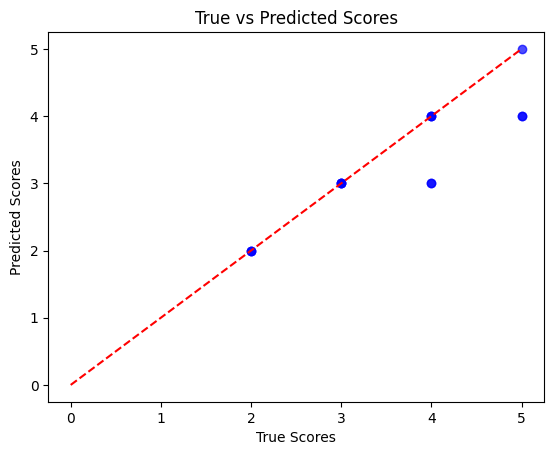

In [ ]:
# Assuming y_test and y_pred have been generated
import numpy as np
import matplotlib.pyplot as plt

# Ensure y_pred is generated by the model
# Example: y_pred = lstm_model.predict(X_test)

# Round predictions to integers (if required)
y_pred_rounded = np.round(y_pred)  # Ensure y_pred exists

# Scatter plot of true vs. predicted scores
plt.scatter(y_test, y_pred_rounded, alpha=0.7, color='blue')
plt.xlabel("True Scores")
plt.ylabel("Predicted Scores")
plt.title("True vs Predicted Scores")
plt.plot([0, max(y_test)], [0, max(y_test)], color='red', linestyle='--')  # Line of perfect prediction
plt.show()



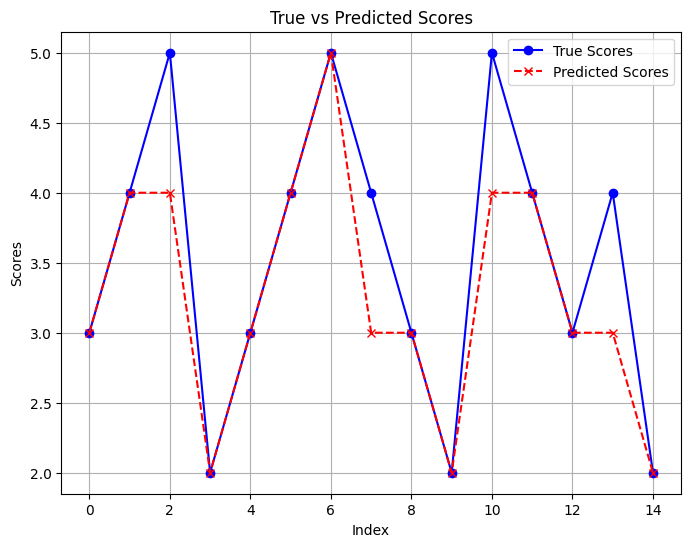

In [ ]:
# Line plot to compare true vs predicted scores
plt.figure(figsize=(8, 6))
plt.plot(y_test, label='True Scores', marker='o', linestyle='-', color='blue')
plt.plot(y_pred, label='Predicted Scores', marker='x', linestyle='--', color='red')
plt.xlabel("Index")
plt.ylabel("Scores")
plt.title("True vs Predicted Scores")
plt.legend()
plt.grid(True)
plt.show()


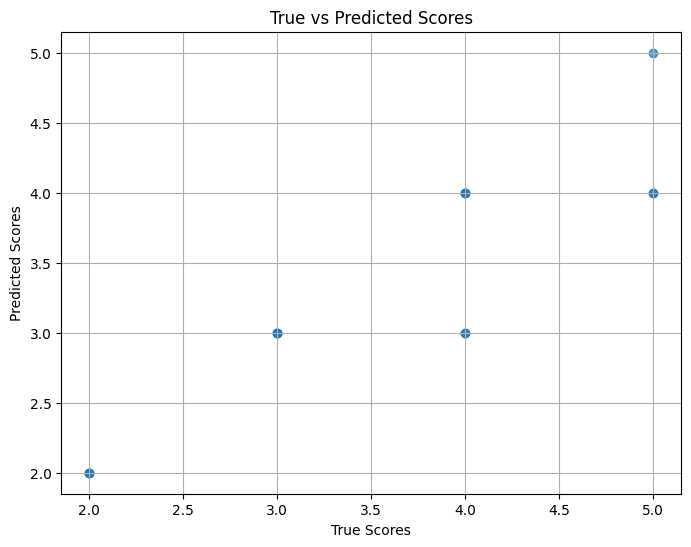

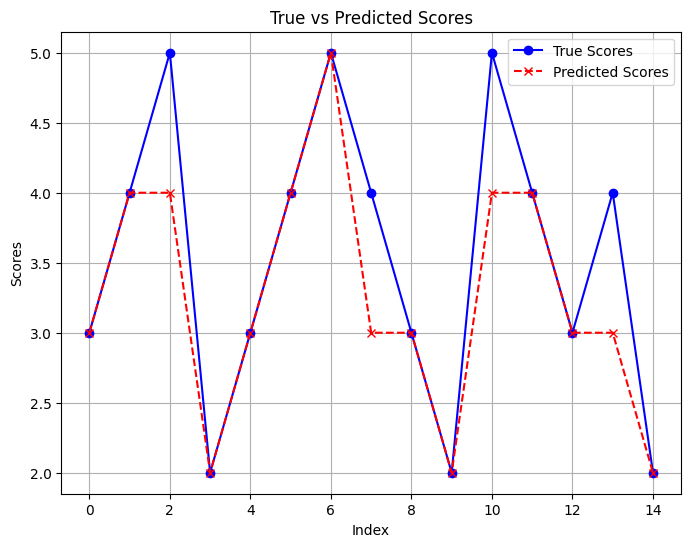

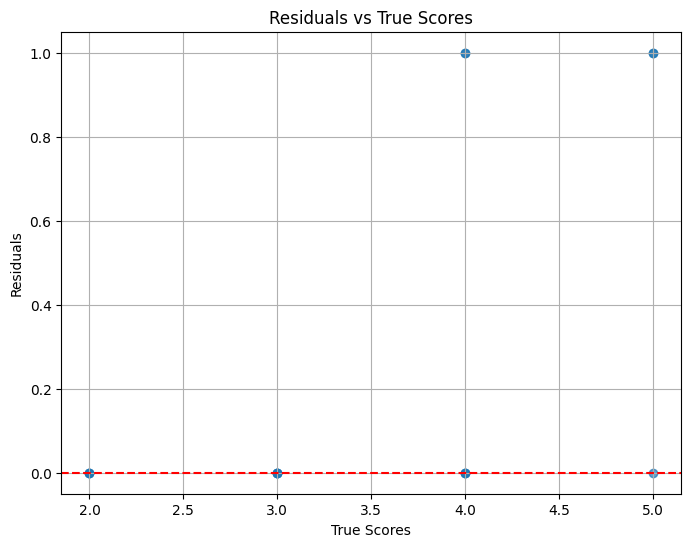

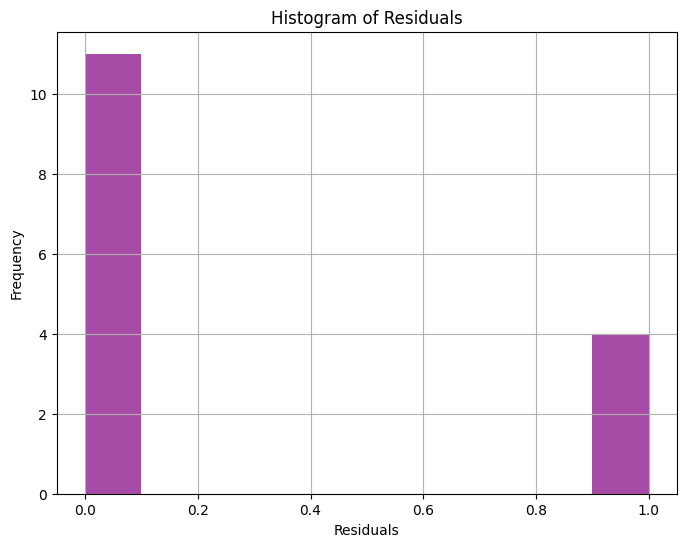

Mean Squared Error (MSE): 0.26666666666666666
Mean Absolute Error (MAE): 0.26666666666666666
Root Mean Squared Error (RMSE): 0.5163977794943222
R-squared (R²): 0.7457627118644068


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
# Visualize the Scatter Plot of True vs Predicted Scores
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("True Scores")
plt.ylabel("Predicted Scores")
plt.title("True vs Predicted Scores")
plt.grid(True)
plt.show()

# Line plot of True vs Predicted Scores
plt.figure(figsize=(8, 6))
plt.plot(y_test, label='True Scores', marker='o', linestyle='-', color='blue')
plt.plot(y_pred, label='Predicted Scores', marker='x', linestyle='--', color='red')
plt.xlabel("Index")
plt.ylabel("Scores")
plt.title("True vs Predicted Scores")
plt.legend()
plt.grid(True)
plt.show()

# Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("True Scores")
plt.ylabel("Residuals")
plt.title("Residuals vs True Scores")
plt.grid(True)
plt.show()

# Histogram of Residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=10, color='purple', alpha=0.7)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.grid(True)
plt.show()

# Calculate and Print MSE, MAE, RMSE
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = math.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")


BERT MODEL
DATA PREPROCESSING

In [ ]:
###BERT MODEL
# Install necessary libraries



from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch

# Load the dataset
training_set_path = '/content/drive/MyDrive/AES/training_set_rel3.xlsx'
training_set = pd.read_excel('/content/drive/MyDrive/AES/training_set_rel3.xlsx')

test_set_path = '/content/drive/MyDrive/AES/test_set.tsv'
test_set = pd.read_csv(test_set_path, sep='\t', encoding='ISO-8859-1')

# Preprocess dataset (remove missing values and reset index)
training_set = training_set[['essay', 'domain1_score']].dropna().reset_index(drop=True)
test_set = test_set[['essay', 'essay_id']].dropna().reset_index(drop=True)

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Custom Dataset class
class EssayDataset(Dataset):
    def __init__(self, texts, scores=None, tokenizer=None, max_length=512):
        self.texts = texts
        self.scores = scores
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        inputs = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt",
        )
        item = {key: val.squeeze(0) for key, val in inputs.items()}
        if self.scores is not None:
            item['labels'] = torch.tensor(self.scores[idx], dtype=torch.float)
        return item

# Tokenize data
train_texts = training_set['essay'].tolist()
train_scores = training_set['domain1_score'].tolist()

train_dataset = EssayDataset(train_texts, train_scores, tokenizer)

test_texts = test_set['essay'].tolist()
test_dataset = EssayDataset(test_texts, tokenizer=tokenizer)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
from transformers import BertForSequenceClassification

# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)
print("BERT model loaded successfully.")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT model loaded successfully.


MODEL TRAINING

In [ ]:

from transformers import TrainingArguments

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",  # Evaluate at the end of each epoch
    save_strategy="epoch",       # Save model at the end of each epoch
    load_best_model_at_end=True,
    num_train_epochs=2,          # Reduced number of epochs for faster training
    per_device_train_batch_size=16,  # Increased batch size for faster training
    per_device_eval_batch_size=16,
    logging_dir='./logs',
    logging_steps=50,            # Increased logging steps interval
    learning_rate=5e-5,
    weight_decay=0.01,
    save_total_limit=2,          # Keep only the best 2 checkpoints
    fp16=True,                   # Enable mixed precision for faster training (requires compatible hardware)
    gradient_accumulation_steps=2,)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Evaluation metrics for regression tasks
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.squeeze(-1)  #predictions are 1D
    mse = mean_squared_error(labels, predictions)
    mae = mean_absolute_error(labels, predictions)
    r2 = r2_score(labels, predictions)
    return {"mse": mse, "mae": mae, "r2": r2}

print("Evaluation metrics function defined.")


from transformers import Trainer
import os
os.environ["WANDB_DISABLED"] = "true"

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=train_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Train the model
print("Starting training...")
trainer.train()
print("Training completed!")

# Evaluate the model
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)




/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-16-341f5634aec5>:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Evaluation metrics function defined.
Starting training...


Epoch,Training Loss,Validation Loss,Mse,Mae,R2
1,21.162200,17.699125,17.699123,1.591008,0.780039
2,13.202900,11.938811,11.938811,1.328300,0.851627


Training completed!


Evaluation Results: {'eval_loss': 11.938811302185059, 'eval_mse': 11.938811302185059, 'eval_mae': 1.328299641609192, 'eval_r2': 0.8516267538070679, 'eval_runtime': 164.3535, 'eval_samples_per_second': 78.958, 'eval_steps_per_second': 4.941, 'epoch': 2.0}


SAVE MDOEL

In [ ]:
from transformers import BertForSequenceClassification

save_path = '/content/drive/MyDrive/AES/BERTtrained_model'

# Save the model and tokenizer
model.save_pretrained(save_path)  # Save the model
tokenizer.save_pretrained(save_path)  # Save the tokenizer

print(f"Model and tokenizer saved successfully at: {save_path}")


Model and tokenizer saved successfully at: /content/drive/MyDrive/AES/BERTtrained_model


MODEL EVALUATION

In [ ]:
#CHECKING MODEL ACCURACY AGAINST SCORES IN DATASET
from transformers import Trainer
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Evaluate the model
trainer = Trainer(
    model=model,                  #trained model
    args=training_args,           # Training arguments
    train_dataset=train_dataset,  # Train dataset
    eval_dataset=test_dataset,    # Validation/test dataset
    compute_metrics=compute_metrics,  # previously defined compute_metrics function
)

# Generate predictions on the test set
predictions_output = trainer.predict(test_dataset)

# Access the predictions from the PredictionOutput object
predictions = predictions_output.predictions

# Convert logits to predicted scores and round them to the nearest whole number
predicted_scores = np.round(predictions.flatten())

# Print the first few predictions (rounded)
print("Rounded Predictions: ", predicted_scores[:10])  # Print first 10 predictions

# If the true labels (scores) are available, print them (use predictions_output.label_ids)
if predictions_output.label_ids is not None:
    print("True Labels: ", predictions_output.label_ids[:10])  # Print first 10 true labels (scores)

# Calculate evaluation metrics (only if true labels are available)
if predictions_output.label_ids is not None:
    mse = mean_squared_error(predictions_output.label_ids, predicted_scores)
    mae = mean_absolute_error(predictions_output.label_ids, predicted_scores)
    r2 = r2_score(predictions_output.label_ids, predicted_scores)

    # Print evaluation results
    print("Mean Squared Error (MSE):", mse)
    print("Mean Absolute Error (MAE):", mae)
    print("R-squared (R2):", r2)


Rounded Predictions:  [ 8. 10.  6.  9.  9.  9.  8.  6.  9.  9.]


In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer
from torch.utils.data import DataLoader
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

# Load the validation dataset
valid_set_path = '/content/drive/MyDrive/AES/valid_set.xlsx'
valid_set = pd.read_excel(valid_set_path)

# Check the structure of the validation set
print(valid_set.head())




   essay_id  essay_set                                              essay  \
0      1788          1  Dear @ORGANIZATION1, @CAPS1 more and more peop...   
1      1789          1  Dear @LOCATION1 Time @CAPS1 me tell you what I...   
2      1790          1  Dear Local newspaper, Have you been spending a...   
3      1791          1  Dear Readers, @CAPS1 you imagine how life woul...   
4      1792          1  Dear newspaper, I strongly believe that comput...   

   domain1_predictionid  domain2_predictionid  
0                  1788                   NaN  
1                  1789                   NaN  
2                  1790                   NaN  
3                  1791                   NaN  
4                  1792                   NaN  


In [ ]:
# Load the trained model and tokenizer
model_path = '/content/drive/MyDrive/AES/BERTtrained_model'
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)

In [ ]:
# Prepare the validation dataset
class EssayDataset(torch.utils.data.Dataset):
    def __init__(self, texts, scores=None, ids=None, tokenizer=None, max_length=512):
        self.texts = texts
        self.scores = scores
        self.ids = ids  # Added essay_id
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        essay_id = self.ids[idx]  # Get essay_id for the current entry
        inputs = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt",
        )
        item = {key: val.squeeze(0) for key, val in inputs.items()}
        if self.scores is not None:
            item['labels'] = torch.tensor(self.scores[idx], dtype=torch.float)
        item['essay_id'] = essay_id  # Add essay_id to the item
        return item

In [ ]:


valid_texts = valid_set['essay'].tolist()  # List of essays
valid_scores = valid_set['domain1_predictionid'].tolist()
valid_ids = valid_set['essay_id'].tolist()  # List of essay IDs

# Create validation dataset
valid_dataset = EssayDataset(valid_texts, valid_scores, tokenizer)

# Create DataLoader for validation
valid_dataloader = DataLoader(valid_dataset, batch_size=8)

VALIDATING MODEL BY PREDICTING ESSAY_ID FROM THE CONTENT

In [ ]:
#VALIDATING MODEL BY PREDICTING ESSAY_ID FROM THE CONTENT

valid_texts = valid_set['essay'].tolist()  # List of essays
valid_scores = valid_set['domain1_predictionid'].tolist()
valid_ids = valid_set['essay_id'].tolist()  # List of essay IDs

# Create validation dataset
valid_dataset = EssayDataset(valid_texts, valid_scores, valid_ids, tokenizer)

# Create DataLoader for validation
valid_dataloader = DataLoader(valid_dataset, batch_size=8)

# Set the model to evaluation mode
model.eval()

# Initialize variables to store predictions and true labels
predictions = []
true_labels = []
essay_ids = []

# Predict on the validation dataset
with torch.no_grad():  # Disable gradient calculations for evaluation
    for batch in valid_dataloader:
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        ids = batch['essay_id']  # Get the essay_id from the batch

# Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

# Get predicted scores
        preds = logits.squeeze().cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(labels.cpu().numpy())
        essay_ids.extend(ids.cpu().numpy())  # Store essay_id for each prediction

# Round predictions and true labels
predictions = [round(pred) for pred in predictions]  # Round predictions to nearest integer
true_labels = [round(label) for label in true_labels]  # Round true labels to nearest integer

# Combine essay_ids, predictions, and true_labels into a DataFrame
validation_results = pd.DataFrame({
    'essay_id': essay_ids,
    'predicted_score': predictions,
    'true_score': true_labels
})

# Print evaluation metrics
mse = mean_squared_error(true_labels, predictions)
mae = mean_absolute_error(true_labels, predictions)
r2 = r2_score(true_labels, predictions)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R2 Score: {r2}")

# Print first few predictions with essay_id and true labels
print("Validation Results (essay_id, predicted_score, true_score):")
print(validation_results.head())

# save the validation results to a CSV file
validation_results.to_csv('/content/drive/MyDrive/AES/validation_results.csv', index=False)

Mean Squared Error: 236958501.10194406
Mean Absolute Error: 13729.713134186819
R2 Score: -3.8871452452428894
Validation Results (essay_id, predicted_score, true_score):
   essay_id  predicted_score  true_score
0      1788                8        1788
1      1789                7        1789
2      1790                8        1790
3      1791                8        1791
4      1792                9        1792


SAVE VALIDATION RESULTS

In [ ]:
import pandas as pd

# Load the validation results
validation_results_path = '/content/drive/MyDrive/AES/validation_results.csv'
validation_results = pd.read_csv(validation_results_path)

# Preview the data
print(validation_results.head())


   essay_id  predicted_score  true_score
0      1788                8        1788
1      1789                7        1789
2      1790                8        1790
3      1791                8        1791
4      1792                9        1792


VISUALS

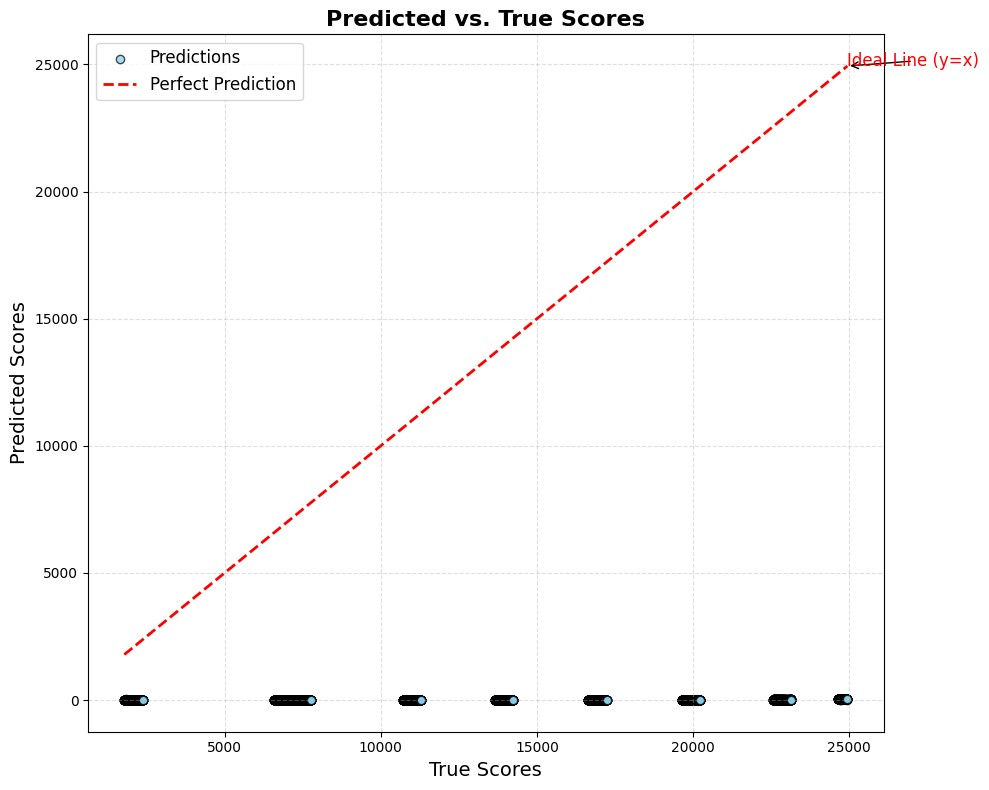

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

# Scatter plot for predictions vs. true scores
plt.scatter(
    validation_results['true_score'],
    validation_results['predicted_score'],
    alpha=0.7,
    edgecolors='k',
    color='skyblue',
    label='Predictions'
)

# Add the perfect prediction line
plt.plot(
    [validation_results['true_score'].min(), validation_results['true_score'].max()],
    [validation_results['true_score'].min(), validation_results['true_score'].max()],
    color='red', linestyle='--', linewidth=2, label='Perfect Prediction'
)

# Titles and labels with improved formatting
plt.title("Predicted vs. True Scores", fontsize=16, fontweight='bold')
plt.xlabel("True Scores", fontsize=14)
plt.ylabel("Predicted Scores", fontsize=14)

# Add grid and legend
plt.grid(alpha=0.4, linestyle='--')
plt.legend(fontsize=12)

# Add annotations for better insights
plt.annotate(
    'Ideal Line (y=x)',
    xy=(validation_results['true_score'].max() - 2, validation_results['true_score'].max() - 2),
    xytext=(validation_results['true_score'].max() - 10, validation_results['true_score'].max()),
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=12, color='red'
)

# Show the plot
plt.tight_layout()
plt.show()


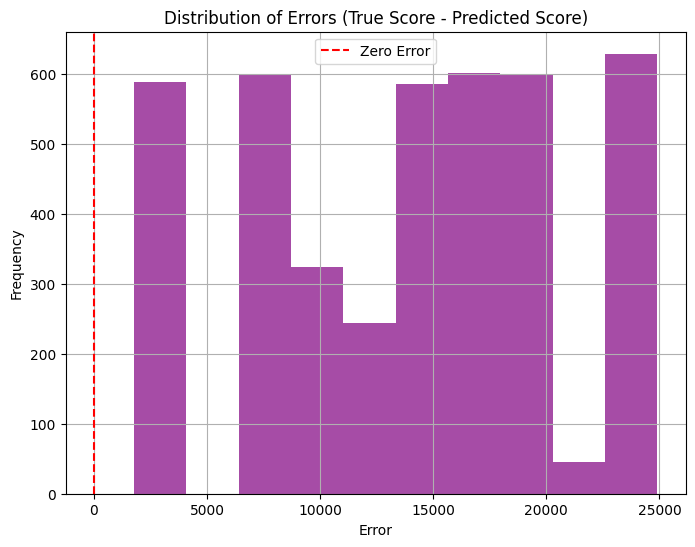

In [ ]:
validation_results['error'] = validation_results['true_score'] - validation_results['predicted_score']

plt.figure(figsize=(8, 6))
plt.hist(validation_results['error'], bins=10, alpha=0.7, color='purple')
plt.title("Distribution of Errors (True Score - Predicted Score)")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.axvline(0, color='red', linestyle='--', label='Zero Error')
plt.legend()
plt.grid()
plt.show()


Columns in validation_results: Index(['essay_id', 'predicted_score', 'true_score'], dtype='object')


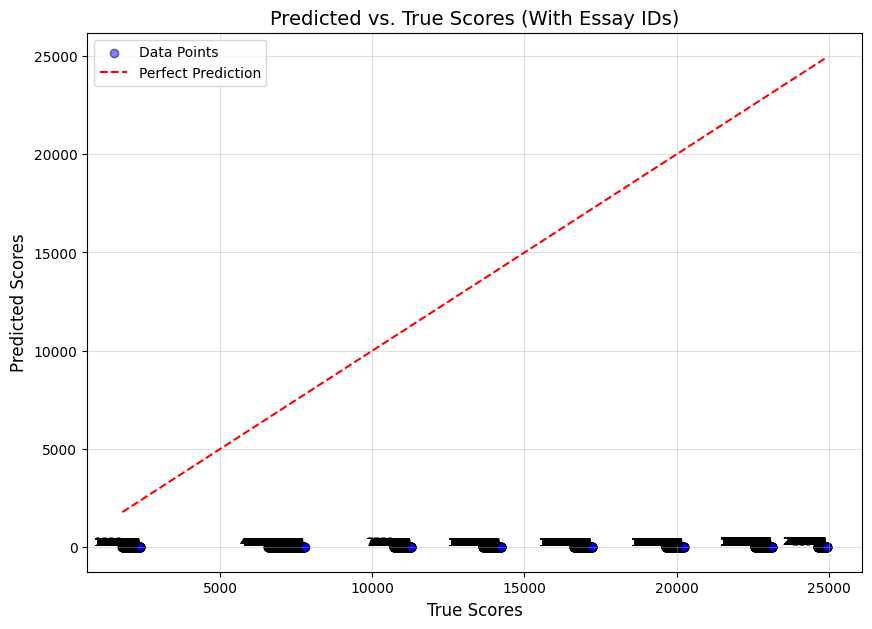

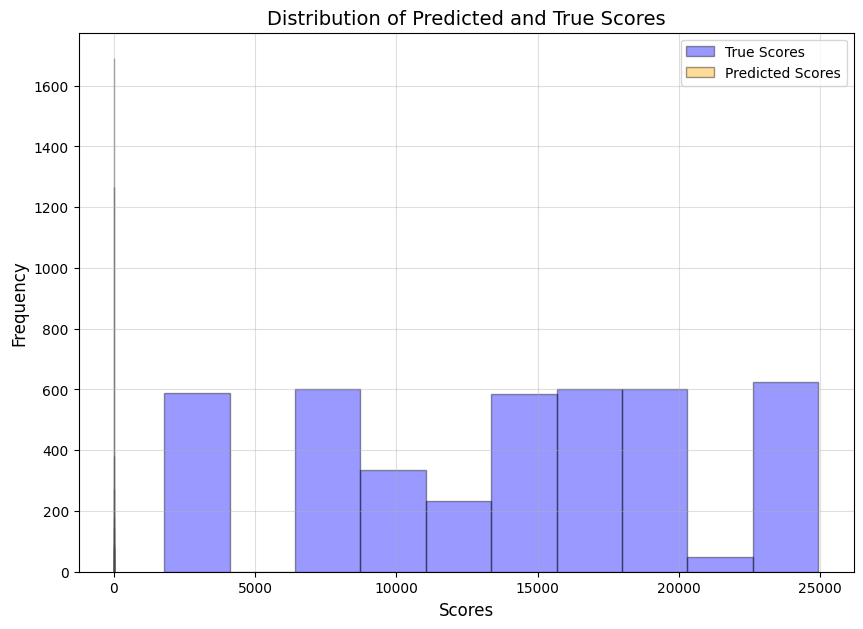

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load validation results from CSV
validation_results_path = '/content/drive/MyDrive/AES/validation_results.csv'
validation_results = pd.read_csv(validation_results_path)

# Check the structure of the DataFrame
print("Columns in validation_results:", validation_results.columns)

# Ensure the necessary columns exist
required_columns = ['essay_id', 'predicted_score', 'true_score']
if not all(col in validation_results.columns for col in required_columns):
    raise KeyError(f"The DataFrame must contain these columns: {required_columns}")


validation_results['set'] = 'validation'

# Visualization 1: Predicted vs. True Scores Scatter Plot
plt.figure(figsize=(10, 7))
plt.scatter(
    validation_results['true_score'], validation_results['predicted_score'],
    alpha=0.5, edgecolors='k', color='blue', label='Data Points'
)
for i, row in validation_results.iterrows():
    plt.text(
        row['true_score'], row['predicted_score'], f"{row['essay_id']}",
        fontsize=8, ha='right', va='bottom', alpha=0.7
    )

# Plot Perfect Prediction Line
plt.plot(
    [validation_results['true_score'].min(), validation_results['true_score'].max()],
    [validation_results['true_score'].min(), validation_results['true_score'].max()],
    color='red', linestyle='--', label='Perfect Prediction'
)
plt.title("Predicted vs. True Scores (With Essay IDs)", fontsize=14)
plt.xlabel("True Scores", fontsize=12)
plt.ylabel("Predicted Scores", fontsize=12)
plt.legend()
plt.grid(alpha=0.4)
plt.show()

# Visualization 2: Transparent Histogram for Score Distributions
plt.figure(figsize=(10, 7))
plt.hist(
    validation_results['true_score'], bins=10, alpha=0.4, label='True Scores', color='blue', edgecolor='black'
)
plt.hist(
    validation_results['predicted_score'], bins=10, alpha=0.4, label='Predicted Scores', color='orange', edgecolor='black'
)
plt.title("Distribution of Predicted and True Scores", fontsize=14)
plt.xlabel("Scores", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.grid(alpha=0.4)
plt.show()
